# Assignment 6 Clustering & NN (ch11&13)

## Wang Yuli 3035028946

This assignment has weighting $3.5$.
The first question about clustering has 35%, and the second question about tiny image classification has 65%.

This is a challenging assignment, so I recommend you start early.

# Clustering for handwritten digits

Supervised learning requires labeled data, which can be expensive to acquire.
For example, a dataset with $N$ samples for classification will require manual labeling $N$ times.

One way to ameliorate this issue is to perform clustering of the raw data samples first, followed by manual inspection and labeling of only a few samples.
Recall that clustering is a form of non-supervised learning, so it does not require any class labels.

For example, say we are given a set of scanned hand-written digit images.
We can cluster them into 10 groups first, manually inspect and label a few images in each cluster, and propagate the label towards the rest of all (unlabeled) samples in each cluster.

The accuracy of such semi-automatic labeling depends on the accuracy of the clustering.
If each cluster (0 to 9) corresponds exactly to hand-written digits 0-9, we are fine.
Otherwise, we have some mis-labeled data.

The goal of this question is to exercise clustering of the scikit-learn digits dataset which has labels, so that we can verify our clustering accuracy.
The specifics are as follows.

You will be judged by the test accuracy of your code, and quality of descriptions of your method.
As a reference, a simple code I (Li-Yi) wrote can achieve about 78% accuracy. Try to beat it as much as you can.

## Training and test data split

We will split the original dataset into training and test datasets
* training for building our clusters
* testing to see if the clusters can predict future data

## Accuracy
What is your clustering accuracy (comparing cluster labels with the ground truth labels), and what are the properties of mis-clustered samples?

## Data preprocessing
Would the original features (pixels) work well, or we need further processing like scaling/standardization or dimensionality-reduction, before clustering?

## Models and hyper-parameters

Let's focus on k-means clustering, as hierarchical and density-based clustering do not provide the predict() method under scikit-learn.

What is the best test performance you can achieve with which hyper-parameters (for k-means, standard scalar, and dimensionality reduction)?

### Hint
We have learned Pipeline and GridSearchCV for cross validation and hyper-parameter tuning.

In [13]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
last updated: 2016-12-19 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scipy 0.17.1
sklearn 0.18


In [26]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Load data

In [51]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # data in pixels
y = digits.target # digit labels

print(X.shape)
print(y.shape)

print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

## Visualize data

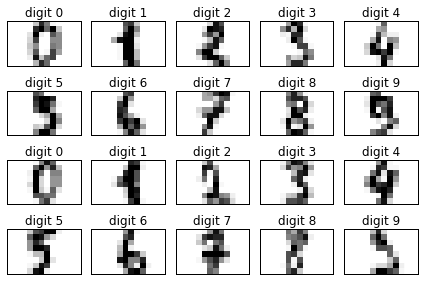

In [28]:
import matplotlib.pyplot as plt
import pylab as pl

num_rows = 4
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(num_rows*num_cols):
    img = digits.images[index]
    label = digits.target[index]
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('digit ' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Data sets: training versus test

In [29]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 1257, test: 540


In [30]:
import numpy as np

# check to see if the data are well distributed among digits
for y in [y_train, y_test]:
    print(np.bincount(y))

[119 133 128 119 120 135 130 122 128 123]
[59 49 49 64 61 47 51 57 46 57]


## Answer

We first write a scoring function for clustering so that we can use for GridSearchCV.
Take a look at use_scorer under scikit learn.

## <font color='purple'>Explanation for scoring function</font>

Since clustering is an unsupurvised learning method, we need to use 2 steps to obtain the accuracy score:
1. Map cluster id to class label (digit id)
2. Use mapped class label from step 1 (predicted) and ground truth to get accuracy score

In order to manually map the clusters to actual class labels, we propose a way to estimate: compare each cluster centroid to references of all 10 classes. The detailed method is as follows:

1. use class labels to split training data set to 10 sets
2. compute the mean vector of the 10 sets, i.e. the averaged hand written digits
3. Use the 10 mean vectors from above as reference.
4. When finish clustering, compare each centroid to all 10 references using $L_2$ to obtain the mapping function. e.g. Suppose centroid $\mu^{(i)}$ is most similar to reference $r^{(j)}$, then cluster id $i$ should be mapped to class $j$

Another important thing to notice is: we have to access our k-means model inside the pipeline to achieve above operations, therefore, we can't use the built-in GridSearchCV algorithm. 

Hence, we will use the <b>pipeline & StratifiedKFold</b> algorithm directly to implement our GridSearchCV


In [123]:
# split data according to their label by: X_train & y_train
# and obtain 10 references for mapping function
X_train_split = {}
for i in range(0, X_train.shape[0]) :
    label = y_train[i]
    if X_train_split.get(label, 'Never') != 'Never':
        X_train_split[label] = np.vstack([X_train_split[label],
                                          X_train[i]])
    else:
        X_train_split[label] = [X_train[i]]

X_train_ref = X_train_split[0].mean(axis=0)
print('class', 0, X_train_split[0].shape, 'average vector dimension', X_train_ref.shape)
for i in range(1,len(X_train_split)):
    newrow = X_train_split[i].mean(axis=0)
    X_train_ref = np.vstack([X_train_ref,newrow])
    print('class', i, X_train_split[i].shape, 'average vector dimension', X_train_ref[i].shape)

class 0 (119, 64) average vector dimension (64,)
class 1 (133, 64) average vector dimension (64,)
class 2 (128, 64) average vector dimension (64,)
class 3 (119, 64) average vector dimension (64,)
class 4 (120, 64) average vector dimension (64,)
class 5 (135, 64) average vector dimension (64,)
class 6 (130, 64) average vector dimension (64,)
class 7 (122, 64) average vector dimension (64,)
class 8 (128, 64) average vector dimension (64,)
class 9 (123, 64) average vector dimension (64,)


/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [170]:
# from centroids, get centroid ids & label ids mapping
from scipy.spatial import distance
def get_cluster_class_mapping(pipe_km, X_train_ref):
    X_train_ref_std = pipe_km.named_steps['scl'].transform(X_train_ref)
    X_train_ref_reduced = pipe_km.named_steps['pca'].transform(X_train_ref_std)
    
    reference = X_train_ref_reduced
    model = pipe_km.named_steps['km']

    centroids = model.cluster_centers_
    cluster_ids = model.predict(centroids) # should follow 0, 1,..
    class_ids = []
    for i in range(0, cluster_ids.shape[0]):
        min_class_id = 0
        min_dist = distance.euclidean(centroids[i],reference[0])
        for j in range(1, len(reference)):
            new_dist = distance.euclidean(centroids[i],reference[j])
            if(new_dist<min_dist):
                min_dist = new_dist
                min_class_id = j
        class_ids.append(min_class_id)
    return class_ids

# map cluster id to class id
def map_cluster_to_class(y_cluster, ref_class_ids):
    return ref_class_ids[y_cluster]


In [171]:
from sklearn.metrics import accuracy_score, make_scorer

def clustering_accuracy_score(y_true, y_pred, ref_class_ids):
    # y_true: labels (digit ids): 0,1,2,3,4,5,6,7,8,9
    # y_pred: cluster ids: 0, 1,...
    y_cm=[]
    for cid in y_pred:
        y_cm.append(map_cluster_to_class(cid, ref_class_ids))
    return accuracy_score(y_true=y_true, y_pred=y_cm)

clustering_accuracy = make_scorer(clustering_accuracy_score) 

Build a pipeline with standard scaler, PCA, and clustering.

In [172]:
# your code
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pipe_km = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('km', KMeans(init='k-means++', 
                                  n_init=10,
                                  max_iter=500,
                                  tol=1e-04,
                                  random_state=0,
                                 ))
                   ])


Use GridSearchCV to tune hyper-parameters.

## <font color='purple'>Explanation on experiments & parameters to tune</font>

with reference to [KMeans Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), we keep the following parameters unchange:
* init: k-means++ for optimal performance
* n_init: 10, the default # of sets of centroids to try, in order to get the best performance
* max. iterations allowed: 500
* tolerance: 1e-04
* random_state: 0

The reason why we keep the above parameters unchange is because those parameters are relatively easy to understand in terms of under-fitting and over-fitting. Since the only formally identified hyper-parameters in this pipeline are PCA's n_components & K-Means' k,

We are only intersted in the following parameters in the pipeline:
* PCA: number of components, i.e. n_components
* K-Means: number of clusters, i.e. k

To observe influence of pre-processing, we perform following experiments:
1. pipeline with standard scalar, PCA & K-means
2. pipeline with standard scalar & K-means
3. perform K-means on raw data

Note*: we know that without standard scalar, data are with high-bias. Hence the PCA performed on un-standardized data is expected to give us bad accuracy. So we skip that


In [194]:
# this is just a sample code for using the above functions defined
pipe_km.set_params(pca__n_components=20,km__n_clusters=20).fit(X_train)

ref_class = get_cluster_class_mapping(pipe_km,X_train_ref)
y_pred = pipe_km.predict(X_test)

print(cluster_ids)
print(ref_class)
clustering_accuracy_score(y_test, y_pred, ref_class)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[6, 9, 0, 4, 2, 7, 7, 3, 2, 2, 2, 5, 7, 1, 6, 4, 3, 6, 1, 8]


0.80185185185185182

## Experiment 1: pipeline with Standard Scalar & PCA

In [196]:
# your code: actual experiment
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

pca_range = range(1, 25)
k_range = range(1, 25)

best_score = 0
best_pca = 0
best_k = 0

for pca_comp in pca_range:
    for num_k in k_range:
        if Version(sklearn_version) < '0.18':
            kfold = StratifiedKFold(y=y_train, 
                                    n_folds=10,
                                    random_state=1)
        else:
            kfold = StratifiedKFold(n_splits=10,
                                    random_state=1).split(X_train, y_train)
        scores = []
        pipe_km.set_params(pca__n_components=pca_comp,
                           km__n_clusters=num_k)
        for k, (train, test) in enumerate(kfold):
            pipe_km.fit(X_train[train])

            y_pred = pipe_km.predict(X_train[test])
            ref_class = get_cluster_class_mapping(pipe_km,X_train_ref)
            score = clustering_accuracy_score(y_train[test], y_pred, ref_class)
            scores.append(score)
        mean_score = np.mean(scores)
        if(mean_score > best_score):
            best_score = mean_score
            best_pca = pca_comp
            best_k = num_k
        # print('finished testing on pca_',pca_comp, ', k_',num_k)
print('best accuracy: ', best_score, 
      'when pca__n_components: ', best_pca,
      ', km__n_clusters: ', best_k)

best accuracy:  0.866448790968 when pca__n_components:  19 , km__n_clusters:  23


In [198]:
# my best model: 
# accuracy: 0.866448790968
# pca components: 19
# clusters: 23

best_model = pipe_km.set_params(pca__n_components=19,km__n_clusters=23)
best_model.fit(X_train)
ref_class = get_cluster_class_mapping(pipe_km,X_train_ref)
y_pred = best_model.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_test, y_pred, ref_class))

#print('Test accuracy: %.3f' % best_model.score(X_test, y_test))

Test accuracy: 0.850


## Experiment 2: pipeline with only Standard Scaler

In [209]:
pipe_km_s = Pipeline([('scl', StandardScaler()),
                    ('km', KMeans(init='k-means++', 
                                  n_init=10,
                                  max_iter=500,
                                  tol=1e-04,
                                  random_state=0,
                                 ))
                   ])
def get_cluster_class_mapping_s(pipe_km, X_train_ref):
    X_train_ref_std = pipe_km.named_steps['scl'].transform(X_train_ref)
    
    reference = X_train_ref_std
    model = pipe_km.named_steps['km']

    centroids = model.cluster_centers_
    cluster_ids = model.predict(centroids) # should follow 0, 1,..
    class_ids = []
    for i in range(0, cluster_ids.shape[0]):
        min_class_id = 0
        min_dist = distance.euclidean(centroids[i],reference[0])
        for j in range(1, len(reference)):
            new_dist = distance.euclidean(centroids[i],reference[j])
            if(new_dist<min_dist):
                min_dist = new_dist
                min_class_id = j
        class_ids.append(min_class_id)
    return class_ids

k_range = range(1, 25)

best_score = 0
best_k = 0

for num_k in k_range:
    if Version(sklearn_version) < '0.18':
        kfold = StratifiedKFold(y=y_train, 
                                n_folds=10,
                                random_state=1)
    else:
        kfold = StratifiedKFold(n_splits=10,
                                random_state=1).split(X_train, y_train)
    scores = []
    pipe_km_s.set_params(km__n_clusters=num_k)
    for k, (train, test) in enumerate(kfold):
        pipe_km_s.fit(X_train[train])

        y_pred = pipe_km_s.predict(X_train[test])
        ref_class = get_cluster_class_mapping_s(pipe_km_s,X_train_ref)
        score = clustering_accuracy_score(y_train[test], y_pred, ref_class)
        scores.append(score)
    mean_score = np.mean(scores)
    if(mean_score > best_score):
        best_score = mean_score
        best_k = num_k
    # print('finished testing on k_',num_k)
print('best accuracy: ', best_score, 
      ', km__n_clusters: ', best_k)

best accuracy:  0.855388291817 , km__n_clusters:  23


In [204]:
# best model:
# accuracy: 0.855388291817
# clusters: 23

best_s = pipe_km_s.set_params(km__n_clusters=23)
best_s.fit(X_train)
ref_class = get_cluster_class_mapping_s(pipe_km_s,X_train_ref)
y_pred = best_s.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_test, y_pred, ref_class))


Test accuracy: 0.874


## Experiment 3: use K-Means on raw data

In [210]:
pipe_km_k = Pipeline([('km', KMeans(init='k-means++', 
                                  n_init=10,
                                  max_iter=500,
                                  tol=1e-04,
                                  random_state=0,
                                 ))])

def get_cluster_class_mapping_k(pipe_km, reference):
    model = pipe_km.named_steps['km']
    centroids = model.cluster_centers_
    cluster_ids = model.predict(centroids) # should follow 0, 1,..
    class_ids = []
    for i in range(0, cluster_ids.shape[0]):
        min_class_id = 0
        min_dist = distance.euclidean(centroids[i],reference[0])
        for j in range(1, len(reference)):
            new_dist = distance.euclidean(centroids[i],reference[j])
            if(new_dist<min_dist):
                min_dist = new_dist
                min_class_id = j
        class_ids.append(min_class_id)
    return class_ids

k_range = range(1, 25)

best_score = 0
best_k = 0

for num_k in k_range:
    if Version(sklearn_version) < '0.18':
        kfold = StratifiedKFold(y=y_train, 
                                n_folds=10,
                                random_state=1)
    else:
        kfold = StratifiedKFold(n_splits=10,
                                random_state=1).split(X_train, y_train)
    scores = []
    pipe_km_k.set_params(km__n_clusters=num_k)
    for k, (train, test) in enumerate(kfold):
        pipe_km_k.fit(X_train[train])

        y_pred = pipe_km_k.predict(X_train[test])
        ref_class = get_cluster_class_mapping_k(pipe_km_k,X_train_ref)
        score = clustering_accuracy_score(y_train[test], y_pred, ref_class)
        scores.append(score)
    mean_score = np.mean(scores)
    if(mean_score > best_score):
        best_score = mean_score
        best_k = num_k
    # print('finished testing on k_',num_k)
print('best accuracy: ', best_score, 
      ', km__n_clusters: ', best_k)

best accuracy:  0.907816735134 , km__n_clusters:  19


In [211]:
# best model:
# accuracy: 0.907816735134
# clusters: 19

best_k = pipe_km_k.set_params(km__n_clusters=19)
best_k.fit(X_train)
ref_class = get_cluster_class_mapping_k(best_k,X_train_ref)
y_pred = best_k.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_test, y_pred, ref_class))

Test accuracy: 0.922


## <font color='purple'>Conclusion 1: Best model & best hyper-parameters</font>

Based on the above 3 experiments (testing with best model done above as well), we got following results:

suppose:
* k: # of clusters
* n: # of pca components

|Method                |best test accuracy  |best hyper-parameters|
| :------------------: |:------------------:| :------------------:|
| Full pipeline        |0.85                | k = 23, n = 19      |
| Standard Scalar + KM |0.874               | k = 23              |
| K-Means on Raw data  |0.922               | k = 19              |

The highest accuracy score is 0.922

Therefore, we found some interesting conclusions:
* With # of clusters > 10, the hard clustering algorithm is actually more robust
* K-Means performs better on raw data rather than scaled data. The raw data will give us high performance with a simpler model. This is because the raw data can better represents how are the data in different grids should be, in order to form a digit.

## Visualize mis-clustered samples, and provide your explanation.

Test accuracy: 0.922
# of misclassified samples:  42


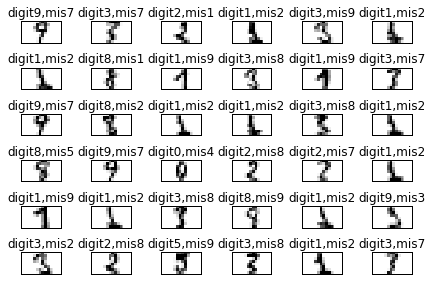

In [259]:
# your code

best = pipe_km_k.set_params(km__n_clusters=19)
best.fit(X_train)
ref_class = get_cluster_class_mapping_k(best,X_train_ref)
y_pred = best.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_test, y_pred, ref_class))

y_cm=[]
for cid in y_pred:
    y_cm.append(map_cluster_to_class(cid, ref_class))
mis = []# misclassified samples indices
for i in range(0,len(y_test)):
    if y_cm[i] != y_test[i]:
        mis.append(i)
print('# of misclassified samples: ', len(mis))

num_rows = 6
num_cols = 6

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(0, num_rows*num_cols):
    img = np.resize(X_test[mis[i]],(8,8))
    label = y_test[mis[i]]
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('digit' + str(label)
                    +',mis' + str(y_cm[mis[i]]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

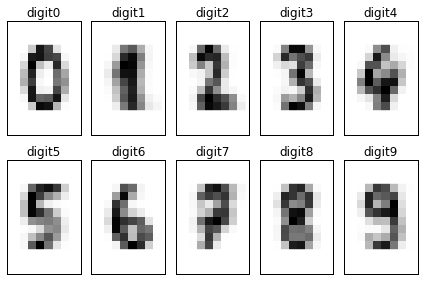

In [260]:
# Plot averaged figures (reference points)
num_rows = 2
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(0, num_rows*num_cols):
    img = np.resize(X_train_ref[i],(8,8))
    label = i
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('digit' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## <font color='purple'>Explanation on mis-clustered samples</font>

We plot the averaged digit images for reference, which are used in the cluster-class mapping procedure.

All together we have 42 misclassified samples in the best model. For simplicity, we just plot 36 of them to take a look. Observing the mis-clustered samples, we can know:
1. The samples are with high noise
2. The noise contained in the misclassfied samples usually make them similar to a wrong image in the reference set. e.g. in the plot above, last line, 3-rd image is actually 5, but misclassified as 9. If we take a closer look at the reference set, we will know that the upper part of that image is with high amount of noise, making it darker in the upper right corner. With this effect, the digit appears to be similar to digit 9.

Therefore, the misclassification is not random, but because of noise exists in the test data set.

# Tiny image classification

We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for image object recognition.
The dataset consists of 50000 training samples and 10000 test samples in 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck; see the link above for more information).
The goal is to maximize the accuracy of your classifier on the test dataset after being optimized via the training dataset.

You can use any learning models (supervised or unsupervised) or optimization methods (e.g. search methods for hyper-parameters).
The only requirement is that your code can run inside an ipynb file, as usual.
Please provide a description of your method, in addition to the code.
Your answer will be evaluated not only on the test accuracy but also on the creativity of your methodology and the quality of your explanation/description.

## Sample code to get you started

This is a difficult classification task.
A sample code below, based on a simple fully connected neural network built via Keras, is provided below.
The test accuracy is about 43%.

In [14]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,keras

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


Using Theano backend.


last updated: 2016-12-19 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
keras 1.1.2


In [73]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
import numpy as np
from sklearn.metrics import accuracy_score

# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_shape = X_train.shape[1:] # [num_rows, num_cols, num_channels]
num_img_pixels = np.prod(img_shape)
num_training_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', img_shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')

# data processing

X_train = X_train.reshape(num_training_samples, num_img_pixels)
X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)


image shape:  (32, 32, 3)
50000 training samples
10000 test samples
10 classes


In [74]:
# build a basic network

model = Sequential()

model.add(Dense(input_dim = num_img_pixels, 
                output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = nb_classes, 
                init = 'uniform', 
                activation = 'softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, 
              metrics = ["accuracy"])


In [75]:
# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 5, 
              batch_size = 10, 
              verbose = 1, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 4s - loss: 2.0287 - acc: 0.2512 - val_loss: 1.8909 - val_acc: 0.3150
Epoch 2/5
45000/45000 [==============================] - 4s - loss: 1.8056 - acc: 0.3496 - val_loss: 1.7535 - val_acc: 0.3664
Epoch 3/5
45000/45000 [==============================] - 4s - loss: 1.7134 - acc: 0.3798 - val_loss: 1.7121 - val_acc: 0.3876
Epoch 4/5
45000/45000 [==============================] - 4s - loss: 1.6551 - acc: 0.4026 - val_loss: 1.6218 - val_acc: 0.4198
Epoch 5/5
45000/45000 [==============================] - 5s - loss: 1.6062 - acc: 0.4216 - val_loss: 1.6376 - val_acc: 0.4144


In [76]:
# evaluate

y_train_pred = model.predict_classes(X_train, verbose=False)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=False)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)


First few predictions:  [6 1 9]
Training accuracy: 0.42678
Test accuracy: 0.4226


## Answer (In progress)

### Loading & Preprocessing

In [77]:
# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# data processing

#X_train = X_train.reshape(num_training_samples, num_img_pixels)
#X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

print('image shape:', img_shape)
print(X_train.shape[0], 'training samples with size:', X_train.shape)
print(X_test.shape[0], 'test samples with size:', X_test.shape)
print('feature example', X_train[0][0][0])
print('class label shape:', y_train_ohe.shape, ', total',y_train_ohe.shape[1], 'classes')

image shape: (32, 32, 3)
50000 training samples with size: (50000, 32, 32, 3)
10000 test samples with size: (10000, 32, 32, 3)
feature example [ 0.23137255  0.24313726  0.24705882]
class label shape: (50000, 10) , total 10 classes


In [78]:
# constants 

from keras import backend as K

img_rows, img_cols = X_train.shape[1], X_train.shape[2]  # input image dimensions
if K.image_dim_ordering() == 'th':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

nb_filters = 16                  # number of convolutional filters to use
filter_size = (4, 4)             # convolotinal filter size
pool_size = (2, 2)               # size of pooling area for max pooling
num_class = y_train_ohe.shape[1] # number of classes

print('convolution input shape:',input_shape)
print('number of convolutional filters:', nb_filters)
print('convolution filter size:',filter_size)
print('pooling size (also stride size):', pool_size)
print(num_class, 'classes')

convolution input shape: (32, 32, 3)
number of convolutional filters: 16
convolution filter size: (4, 4)
pooling size (also stride size): (2, 2)
10 classes


In [88]:
# build a network

net = Sequential()

# convolutional layers
net.add(Convolution2D(nb_filters, filter_size[0], filter_size[1], 
                      border_mode='valid',
                      input_shape=input_shape,
                      activation='relu'))

# net.add(Convolution2D(nb_filters, filter_size[0], filter_size[1], 
#                       border_mode='valid',
#                       input_shape=input_shape,
#                       activation='relu'))

# pooling layers
net.add(MaxPooling2D(pool_size=pool_size))
net.add(Dropout(0.25))  # reduce overfitting

# fully-connected layers
net.add(Flatten())
# net.add(Dense(output_dim=64, activation = 'tanh'))
# net.add(Dropout(0.25))
net.add(Dense(output_dim=32, activation = 'tanh'))
net.add(Dropout(0.25))
net.add(Dense(output_dim=num_class, activation = 'softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

net.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


In [89]:
# training
_ = net.fit(X_train, y_train_ohe, 
              nb_epoch = 5, 
              batch_size = 10, 
              verbose = 1, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 25s - loss: 1.7868 - acc: 0.3563 - val_loss: 1.5056 - val_acc: 0.4658
Epoch 2/5
45000/45000 [==============================] - 26s - loss: 1.5309 - acc: 0.4493 - val_loss: 1.3805 - val_acc: 0.5076
Epoch 3/5
45000/45000 [==============================] - 27s - loss: 1.4351 - acc: 0.4864 - val_loss: 1.3359 - val_acc: 0.5210
Epoch 4/5
45000/45000 [==============================] - 27s - loss: 1.3853 - acc: 0.5076 - val_loss: 1.2624 - val_acc: 0.5522
Epoch 5/5
45000/45000 [==============================] - 28s - loss: 1.3420 - acc: 0.5227 - val_loss: 1.2465 - val_acc: 0.5626


In [90]:
# evaluate
y_train_pred = net.predict_classes(X_train, verbose=False)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = net.predict_classes(X_test, verbose=False)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)


First few predictions:  [6 9 8]
Training accuracy: 0.57612
Test accuracy: 0.5578


## Your description
with the following main parts:

<dl>

<dt>Introduction</dt>
<dd>
At a high-level, what are the approaches you considered and why?
</dd>

<dt>Method</dt>
<dd>
Describe your entire pipeline, such as data-preprocessing, model selection, and hyper-parameter optpimization.
</dd>

<dt>Results</dt>
<dd>
Describe the experimental process you took to arrive at the solution.
For example:
(1) compare your approach against other approach(es) you have tried, as
well as the MLP baseline classifer.
(2) compare against different settings of model parameters, e.g. regularization type/strength, number of hidden units or structure of a neural network, types of kernel in a SVM, etc. 

<dt>Conclusion</dt>
<dd>
Summarize what you have learned from the experiments and discuss the limitations and potential future improvements of your current method.
</dd>

<dt>References</dt>
<dd>
Cite any publically available code, blog posts, research papers, etc. you used or got ideas from.
</dl>

### <font color='purple'>Introduction</font>

#### Approach 1: Without ANNs, use GridSearchCV to tune hyper-parameters
1. Dimension Reduction: PCA(different kernels), LDA
2. Basic Classifiers: Logistic Regression, SVM(different kernels), Random Forest, KNN
3. Ensemble learning with above classifiers

#### Approach 2: With ANNs, use human intuition to tune hyper-parameters
1. Base MLP
2. Base MLP with Dimension Reduction(PCA, LDA) before
3. Convolutional Neural Network
4. Ensemble learning with different CNNs

#### Approaches pruned:
1. Unsupervised learning using clustering
2. Decision Tree Naive Bayes x

### <font color='purple'>References</font>
* Intro to CNN from YouTube chanel Nervana: [(3) Convolutional Neural Networks](https://www.youtube.com/watch?v=SQ67NBCLV98)
* CNN process overview from YouTube channel Brandon Rohrer [How Convolutional Neural Networks work](https://www.youtube.com/watch?v=FmpDIaiMIeA)
* [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/) on github.io
* Keras example code on using CNN on MNIST data set: [keras/examples/mnist_cnn.py](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py)
* [Keras Documentation](https://keras.io/) on layers, activations, optimizers
* Theano Documentation on [LeNet](http://deeplearning.net/tutorial/lenet.html)
* Jason Brownlee's post on Deep Learning, June 24, 2016: [Crash Course on CNN](http://machinelearningmastery.com/crash-course-convolutional-neural-networks/)
* Classification [research collection](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) for dataset CIFAR-10

### <font color='purple'>Relative Intuitions on CNN workflow</font>

Stacking:
* Convolution: add info in each pixel, so that one image becomes a stack of filtered images
* Rectified Linear Units (ReLUs): element-wise normalization: negative -> 0
* Pooling: shrinking image size

Decision making:
* Fully-connected layer
